In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing  import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline 

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_p1.csv')
df.head()

,date,Kwh,LaCR,LeCR,co2,LaF,LeF
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0


In [3]:
# 1.1 date 3개의 파생변수 
# month : 해당 시각의 월 정보
# day : 해당 시각의 일자 정보, 일요일-0, 월요일-1 ~ 토요일-6
# nsd : 해당 시각의 일자의 자정으로부터 소요된 총 분(minute)
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')

df['month'] = df['date'].dt.month

# dayofweek 0: 월요일 / 6: 일요일 6 + 1 % 7 
df['day'] = (df['date'].dt.dayofweek + 1) % 7

# nds 
df['nsd'] = df['date'].dt.minute + df['date'].dt.hour * 60 


In [4]:
df['ind11'] = (((df['month'] + df['day'] + df['nsd']) % 11 == 0) & ((df['month'] + df['day'] + df['nsd']) % 22 != 0)).astype(int)
df['ind22'] = ((df['month'] + df['day'] + df['nsd']) % 22 == 0).astype(int)

df.head()

,date,Kwh,LaCR,LeCR,co2,LaF,LeF,month,day,nsd,ind11,ind22
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,1,1,15,0,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1,1,30,0,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,1,1,45,0,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,1,1,60,0,0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,1,1,75,1,0


In [5]:
# 파생변수명(Kwh8) : Kwh컬럼의 값이 4.1 초과일 경우 1 그 외 0 
df['Kwh8'] = df['Kwh'].map(lambda x : 1 if x > 4.1 else 0)
print(df['Kwh8'].value_counts()) 

Kwh8
1    18815
0    16225
Name: count, dtype: int64


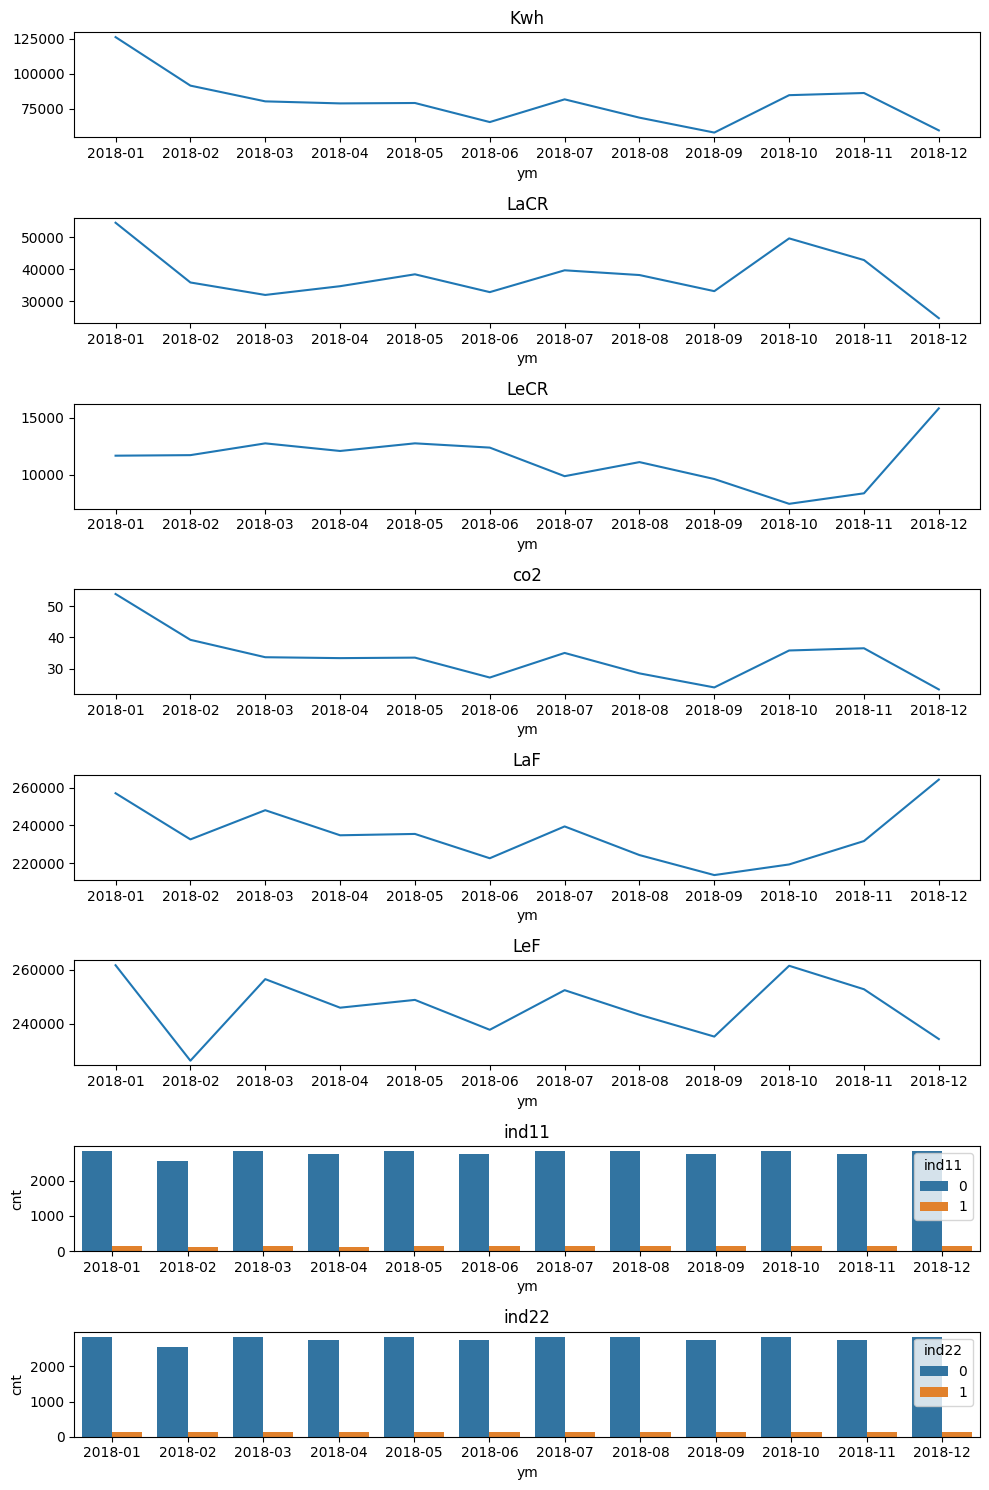

In [6]:
p_df = df.copy()

p_df['ym'] = p_df['date'].dt.strftime('%Y-%m')

plot_cols = ['Kwh', 'LaCR', 'LeCR', 'co2', 'LaF', 'LeF' , 'ind11' ,'ind22','ym'] 

fig, axes = plt.subplots(8,1 , figsize = (10, 15))

for i, col in zip(axes.flatten(), plot_cols) : 
    if col not in ['ind11', 'ind22'] : 
        target= p_df.groupby('ym')[col].sum()
        sns.lineplot(x = target.index, y = target.values, ax = i)
        i.set_title(f'{col}')

    else : 
        target = p_df.groupby(['ym', col]).size().reset_index(name = 'cnt')
        sns.barplot(x = target.ym , y = target.cnt, hue = target[col], ax = i)
        i.set_title(f'{col}')

plt.tight_layout()
plt.show()

##### Kwh8를 종속 변수로 하여(Kwh제거) 분류 모델을 학습하고 평가하라. 서포트벡터머신과 랜덤포레스트를 사용하라. confusionmatrix를 해석
- 파생변수 ind11칼럼의 값이 1인 데이터만 훈련에 사용할 것, ind22칼럼의 값이 1인 데이터만 테스트에 사용할 것
- 모든 모델링은 그리드서치를 통해서 최적 파라미터를 산출할 것 

In [7]:
c_df = df.drop(columns = ['date' , 'month','day','Kwh']) 

train_set = c_df[c_df['ind11'] == 1] 
x_train = train_set.drop(columns = 'Kwh8', axis = 1)
y_train = train_set['Kwh8']

test_set = c_df[c_df['ind22'] == 1]
x_test = test_set.drop(columns = 'Kwh8', axis = 1)
y_test = test_set['Kwh8'] 

#### Random Forest, SVC - GridSearch & Confusion Matrix 

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=10))])


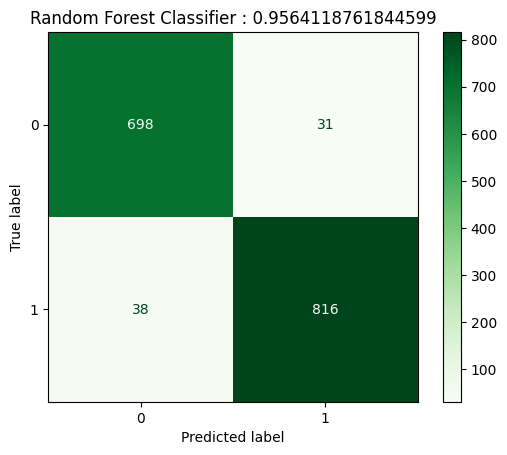

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC(C=1.5))])


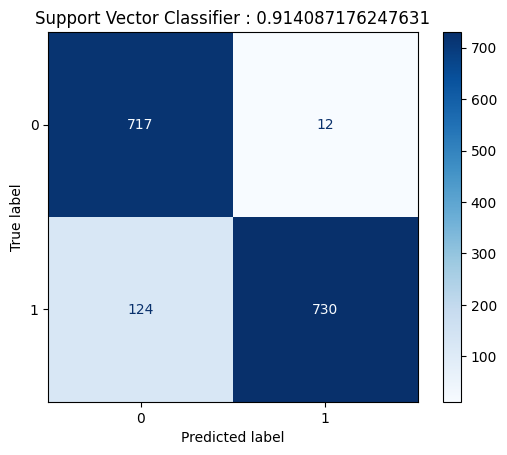

  Model Name     Score
0         RF  0.956412
1        SVC  0.914087


In [8]:
def classifier(name, model, x_train, x_test, y_train, y_test) : 

    # 1.Pipeline 
    pipe = Pipeline([
        ('scaler', StandardScaler()) , 
        ('model', model)
    ])

    if name == 'RF' : 
        param_grid = {
            'model__n_estimators': [1, 10, 100],
            'model__min_samples_split': [2, 3, 4],
            'model__min_samples_leaf': [1, 2]
        }
        cmap = plt.cm.Greens
        title = 'Random Forest Classifier'

    elif name == 'SVC':
        param_grid = {
            'model__C': [0.1, 1, 1.5, 2.0],
            'model__kernel': ['rbf', 'linear']
        }
        cmap = plt.cm.Blues 
        title = 'Support Vector Classifier'

    grid = GridSearchCV(pipe, param_grid, cv = 3, scoring = 'accuracy') 
    grid.fit(x_train, y_train)
    print(grid.best_estimator_)

    best_model = grid.best_estimator_
    best_pred = best_model.predict(x_test)
    score = accuracy_score(y_test, best_pred)

    cm = confusion_matrix(y_test, best_pred)
    display = ConfusionMatrixDisplay(confusion_matrix = cm)
    display.plot(cmap = cmap)
    plt.title(f'{title} : {score}')
    plt.show()

    return best_model, score 

result = []
res = []
for name, model in [['RF', RandomForestClassifier()], ['SVC' , SVC()]] : 
    best_model, score = classifier(name, model, x_train, x_test, y_train, y_test) 
    result.append({
        'Model Name' : name, 
        'Score' : score
    })
    res.append([name, score])

print(pd.DataFrame(result))

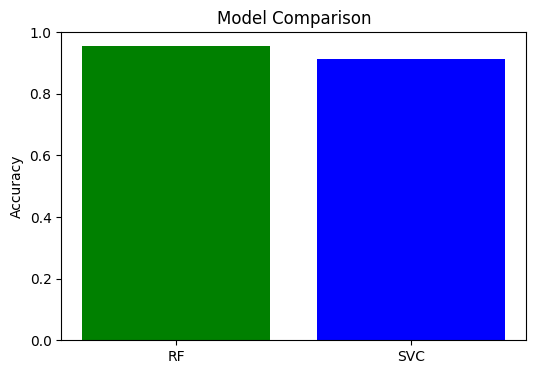

In [9]:
# 정확도 비교 그래프
model_names = [r[0] for r in res]
scores = [r[1] for r in res]

plt.figure(figsize=(6, 4))
plt.bar(model_names, scores, color=['green', 'blue'])
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()    
    

In [10]:
# 1-6 Kwh를 종속 변수로 하여(Kwh8 제거) 회귀 모델을 학습하고 평가하라. 서포트벡터머신과 랜덤포레스트를 사용
l_df = df.drop(columns = ['date' , 'month','day','Kwh8']) 

train_set = l_df[l_df['ind11'] == 1] 
x_train = train_set.drop(columns = 'Kwh', axis = 1)
y_train = train_set['Kwh']

test_set = l_df[l_df['ind22'] == 1]
x_test = test_set.drop(columns = 'Kwh', axis = 1)
y_test = test_set['Kwh'] 


Best Params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}
Random Forest Regression - MSE: 7.6970, R²: 0.9930


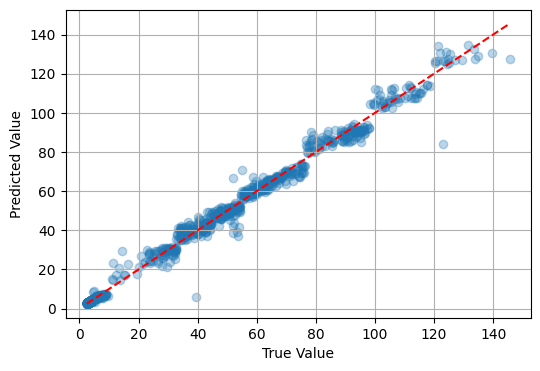

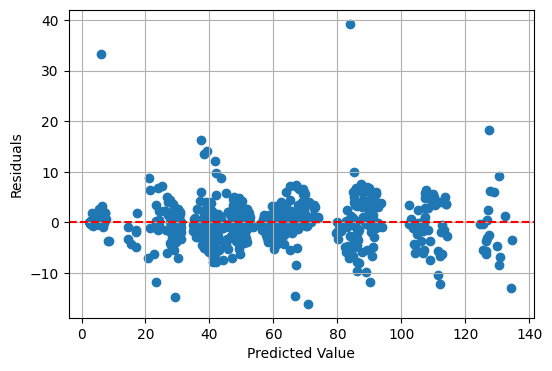

Best Params: {'model__C': 10, 'model__epsilon': 0.2, 'model__kernel': 'rbf'}
Support Vector Regression - MSE: 115.4537, R²: 0.8945


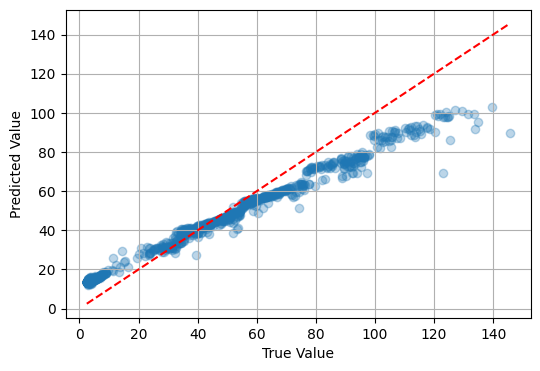

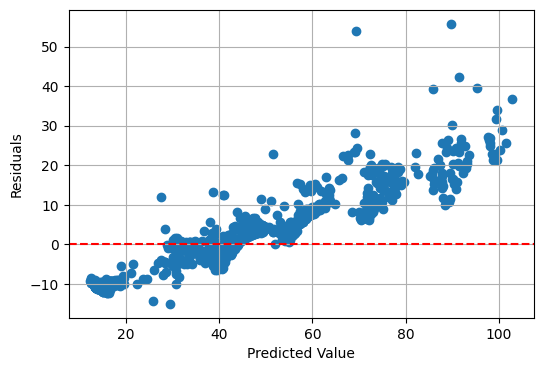

  Model_Name     Score
0         RF  0.992969
1        SVR  0.894531


In [11]:
def regressor(name, model, x_train, y_train, x_test, y_test) : 
    # 1. PipeLine
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    if name == 'SVR':
        param_grid = {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['rbf', 'linear'],
            'model__epsilon': [0.1, 0.2]
        }
        title = 'Support Vector Regression'

    elif name == 'RF':
        param_grid = {
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_leaf': [1, 2]
        }
        title = 'Random Forest Regression'

    # GridSearchCV
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid.fit(x_train, y_train)
    print("Best Params:", grid.best_params_)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(x_test)

    # 평가 지표
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{title} - MSE: {mse:.4f}, R²: {r2:.4f}")

    # 시각화 : 실제  VS 예측 - 모델성능 
    plt.figure(figsize = (6,4))
    plt.scatter(y_test, y_pred, alpha = 0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test) , max(y_test)], 'r--')
    plt.xlabel("True Value")
    plt.ylabel("Predicted Value") 
    plt.grid(True)
    plt.show()

    # 잔차 시각화 (실제 - 예측)
    resid = y_test - y_pred
    plt.figure(figsize = (6,4))
    plt.scatter(y_pred, resid)
    plt.axhline(0, color = 'red', linestyle = '--')
    plt.xlabel("Predicted Value")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()

    return best_model, r2

res = []
for name, model in [['RF' , RandomForestRegressor()] , ['SVR', SVR()]] : 
    best_model, r2 =  regressor(name, model, x_train, y_train, x_test, y_test) 
    res.append({
        'Model_Name' : name, 
        'Score' : r2
    })

print(pd.DataFrame(res))

### Part 2.

In [12]:
p = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_p2.csv')
p.head()

,발전기명,일자,설비용량,0시,1시,2시,3시,4시,5시,6시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,a,2020-01-01,263.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,93.280,53.840,21.630,5.690,4.610,4.270,1.330,0.530,0.0,0.0
1,b,2020-01-01,245.725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88.250,51.059,22.283,5.244,4.183,3.848,1.290,0.564,0.0,0.0
2,c,2020-01-01,254.425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.641,50.344,22.072,5.652,4.495,4.089,1.240,0.526,0.0,0.0
3,d,2020-01-01,250.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,86.995,51.953,21.831,6.149,4.666,4.141,1.228,0.491,0.0,0.0
4,a,2020-01-02,263.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.000,25.860,8.310,4.090,0.730,1.070,0.390,0.020,0.0,0.0


In [13]:
pivot_p = p.melt(id_vars = ['일자','발전기명','설비용량'], var_name = '시간', value_name = '발전량')
pivot_p['date'] = pd.to_datetime(pivot_p['일자'].astype(str) + ' ' +pivot_p['시간'].str.split('시').str[0].str.zfill(2))

final_p = pivot_p[['date','발전기명','설비용량','발전량']]

In [14]:
w = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_p2_sub.csv')
w.head()

,일시,기온,강수량(mm),습도,적설(cm),전운량(10분위),일조(hr),일사량
0,2020-01-01 00:00,2.4,NaN,63.0,0.0,9,0.0,0.0
1,2020-01-01 01:00,2.6,0.0,63.0,0.0,9,0.0,0.0
2,2020-01-01 02:00,2.7,0.0,68.0,0.0,9,0.0,0.0
3,2020-01-01 03:00,3.2,0.0,69.0,0.0,9,0.0,0.0
4,2020-01-01 04:00,3.0,0.0,65.0,0.0,9,NaN,0.0


In [15]:
# 1. 컬럼 정리
w.columns = [col.split('(')[0] for col in w.columns]

# 2. 일시 
w['일시'] = pd.to_datetime(w['일시'])

# 3. Fillna 
w['강수량'] = w['강수량'].fillna(0)
w['일조'] = w['일조'].fillna(0)

# 4. 기온 
w['기온'] = w['기온'].combine_first((w['기온'].fillna(method = 'bfill') + w['기온'].fillna(method = 'ffill')) / 2)

In [16]:
# Merge 
m_df = pd.merge(final_p, w, how = 'left', left_on = 'date', right_on = '일시')
m_df = m_df[m_df.columns.difference(['일시'])]

#### 2-2. 전처리 데이터를 기준으로 아래 조건으로 train,test 데이터를 나눈다. 데이터 분리 후 train 데이터의 기초 통계량을 확인하라
- a발전기의 12시~18시의 데이터만 모델링에 사용
- 2020년도, 2021년도는 train, 2022년도는 test 데이터로 사용

In [17]:
model_df = m_df[(m_df['발전기명'] =='a') & (m_df['date'].dt.hour.isin(range(12,19)))].reset_index(drop = True) 

# 2. 구분 
train_set = model_df[model_df['date'].dt.year.isin([2020,2021])]
test_set = model_df[model_df['date'].dt.year.isin([2022])]

# Train의 기초 통계량 
print(train_set.iloc[:,1:].describe()) 

               강수량           기온          발전량         설비용량           습도  \
count  5110.000000  5110.000000  5110.000000  5110.000000  5110.000000   
mean      0.206419    18.723386    78.277661   290.191007    65.166928   
std       1.762871     7.671290    67.321926    14.075334    15.126223   
min       0.000000    -2.000000     0.030000   263.225000    14.000000   
25%       0.000000    12.800000    17.890000   282.355000    54.000000   
50%       0.000000    19.100000    58.860000   289.698500    65.000000   
75%       0.000000    24.700000   131.525000   299.697000    76.000000   
max      74.600000    35.600000   247.560000   318.119000   100.000000   

               일사량           일조           적설          전운량  
count  5110.000000  5110.000000  5110.000000  5110.000000  
mean      1.413086     0.497162     0.027926     5.985519  
std       1.054632     0.440233     0.392822     3.686239  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.470000     0.000000  

#### 2.3 변수간 상관관계 [발전량과 나머지 변수]

In [18]:
# 1. 상관계수 도출하기
cor_col = model_df.columns.difference(['date','발전기명'])
cor_df = model_df[cor_col]

cor_mat = cor_df.corr(method = 'pearson').iloc[:,2]
cor_mat.to_frame().T

,강수량,기온,발전량,설비용량,습도,일사량,일조,적설,전운량
발전량,-0.100793,0.143372,1.0,0.033608,-0.366418,0.838982,0.576096,-0.059037,-0.458936


In [19]:
# 2. p_value 검정하기 
from scipy.stats import pearsonr

res = []
for col in cor_col : 
    stat, p_val = pearsonr(model_df['발전량'] , model_df[col])
    if p_val < 0.05 : 
        decision = "귀무가설기각-상관이있다" 
    else : 
        decision = "귀무가설채택-상관이없다"
    res.append({
        '변수' : col, 
        'cor' : stat, 
        'p_value' : p_val, 
        'decision' : decision        
    }) 
print(pd.DataFrame(res))

     변수       cor        p_value      decision
0   강수량 -0.100793   9.113187e-19  귀무가설기각-상관이있다
1    기온  0.143372   1.736017e-36  귀무가설기각-상관이있다
2   발전량  1.000000   0.000000e+00  귀무가설기각-상관이있다
3  설비용량  0.033608   3.253676e-03  귀무가설기각-상관이있다
4    습도 -0.366418  3.096382e-242  귀무가설기각-상관이있다
5   일사량  0.838982   0.000000e+00  귀무가설기각-상관이있다
6    일조  0.576096   0.000000e+00  귀무가설기각-상관이있다
7    적설 -0.059037   2.312070e-07  귀무가설기각-상관이있다
8   전운량 -0.458936   0.000000e+00  귀무가설기각-상관이있다


#### 2-4 발전량을 종속변수로 하여 2개의 회귀모델링을 진행하고 모델을 평가

In [20]:
x_train = train_set.drop(columns = ['date','발전기명','발전량'])
y_train = train_set['발전량']

x_test = test_set.drop(columns = ['date','발전기명','발전량'])
y_test = test_set['발전량']

,Model,MSE,R2_score
0,RF,35.307831,0.770289
1,LC,36.738638,0.751294


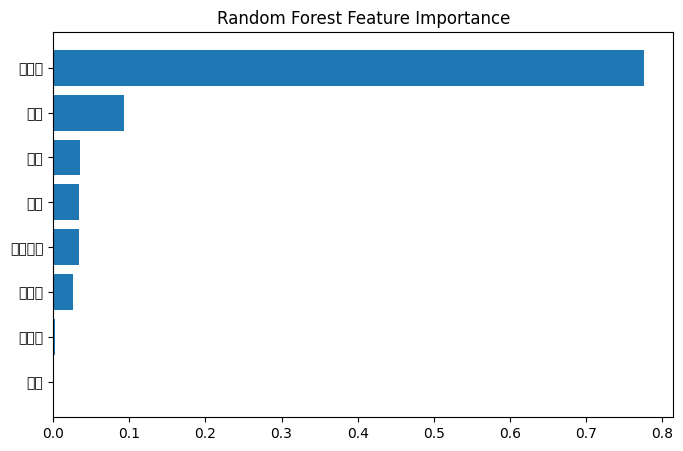

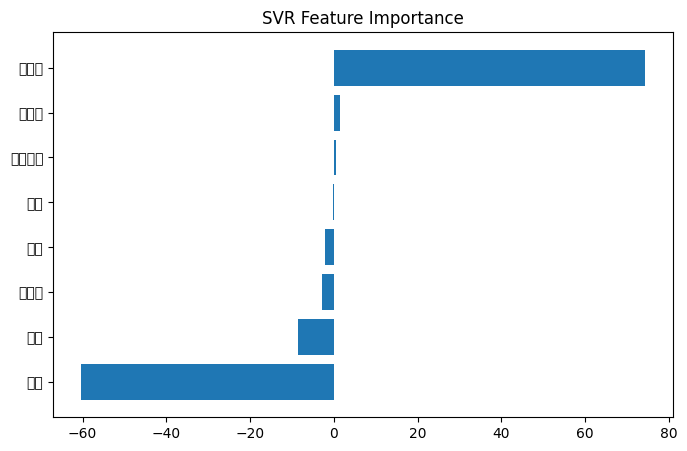

In [21]:
def reg_model(name, model, x_train, y_train, x_test, y_test) : 

    pipe = Pipeline([
        ('scaler', StandardScaler()) , 
        ('model', model)
    ])

    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    mse = np.sqrt(mean_squared_error(y_test,pred))
    r2 = r2_score(y_test, pred)

    if name == 'RF' : 
        imp = pipe.named_steps['model'].feature_importances_ 
        title = "Random Forest Feature Importance"

    elif name == 'LC' : 
        imp  = pipe.named_steps['model'].coef_
        title = "SVR Feature Importance"

    imp = pd.Series(imp, index = x_train.columns).sort_values()

    plt.figure(figsize = (8,5)) 
    plt.barh(imp.index, imp.values)
    plt.title(f'{title}')

    return name, mse, r2 , imp

res = []
for name, model in [['RF', RandomForestRegressor()] , ['LC', LinearRegression()]] : 
    name, mse, r2 , imp = reg_model(name, model, x_train, y_train, x_test, y_test)
    res.append(
        {'Model':name,
         'MSE': mse,
         'R2_score' : r2
        })
    #print(imp)
pd.DataFrame(res)


#### 3.1 통계 - 선형회귀기본가정

In [32]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_s1.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT1,LSTAT2,MEDV
0,0.00632,18.0,2.31,0.0,0.538,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,5.0520,24.0
1,0.02731,0.0,7.07,0.0,0.469,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,9.4440,21.6
2,0.02729,0.0,7.07,0.0,0.469,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,3.8970,34.7
3,0.03237,0.0,2.18,0.0,0.458,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,2.9410,33.4
4,0.06905,0.0,2.18,0.0,0.458,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,5.4075,36.2


In [33]:
import statsmodels.api as sm 

x = df.drop('MEDV', axis = 1)
y = df['MEDV']

add_x = sm.add_constant(x)
model = sm.OLS(y, add_x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     87.03
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          2.09e-118
Time:                        13:23:58   Log-Likelihood:                -1538.2
No. Observations:                 506   AIC:                             3104.
Df Residuals:                     492   BIC:                             3164.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.4437      3.888     17.860      0.0

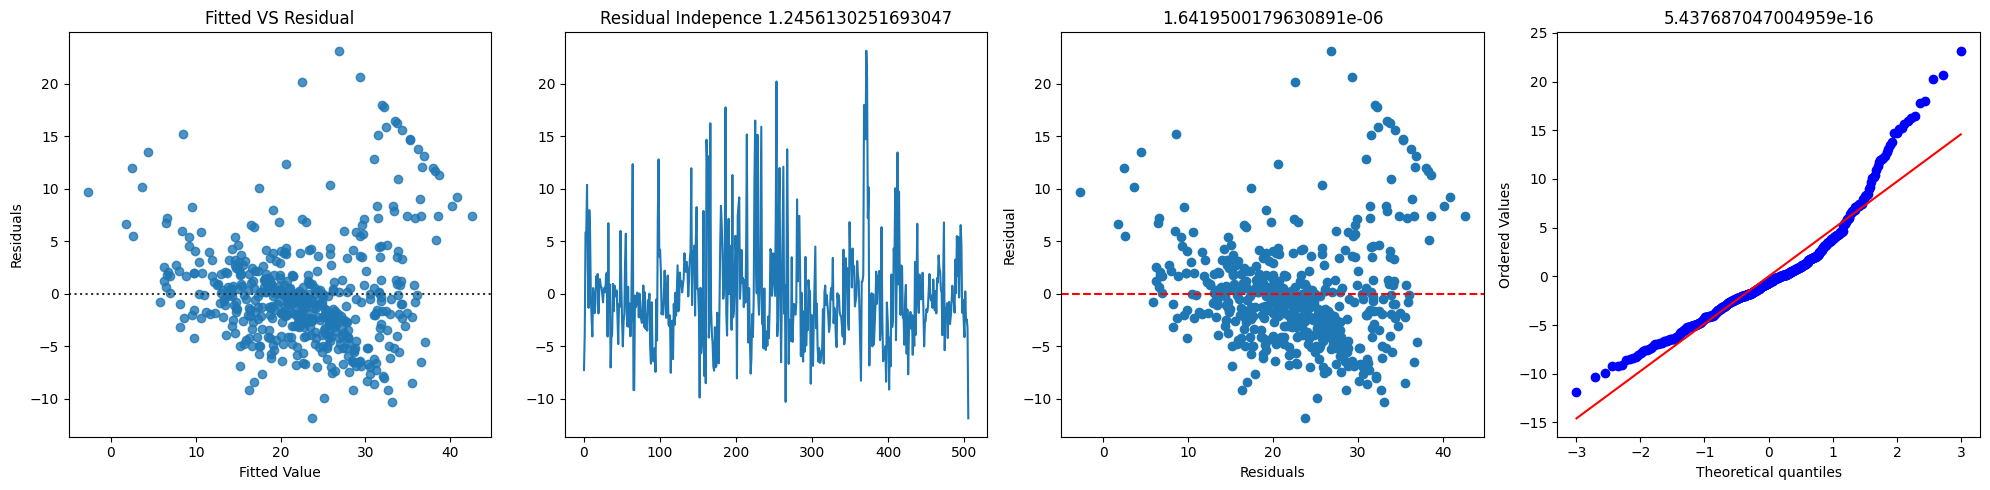

In [34]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, probplot

# 잔차
resid = model.resid

# 예측값
fitted = model.fittedvalues 

fig, axes = plt.subplots(1, 4, figsize=(20, 5)) 
# 1. 선형성 - 잔차 VS 예측값 : 잔차가 무작위로 분표하면 선형성을 충족한다. 
sns.residplot(x = fitted, y = resid, line_kws={'color': 'red'} , ax = axes[0])
axes[0].set_xlabel("Fitted Value")
axes[0].set_ylabel("Residuals")
axes[0].set_title('Fitted VS Residual')

# 2. 독립성 - 잔차 플롯 + Durbin-Watson 통계량
dw = durbin_watson(resid)
axes[1].plot(resid.values)
axes[1].set_title(f'Residual Indepence {dw}') 

# 3. 등분산성 - Breusch-Pagan 테스트 + 잔차 vs 예측값 산점도 
bp = het_breuschpagan(resid, model.model.exog)
p_value = bp[1]

axes[2].axhline(0, color='red', linestyle='--')
axes[2].scatter(fitted, resid)
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Residual')
axes[2].set_title(f'{p_value}')

# 4. 정규성 - 잔차는 정규분포이다.  (QQ-plot)
probplot(resid, dist = 'norm', plot = axes[3])
shap = shapiro(resid).pvalue 
axes[3].set_title(f'{shap}')

plt.tight_layout()
plt.show()


#### 3.2 변수간 관계 검토 문제점 해결 방안 2가지

    level_0 level_1      corr
32    INDUS     NOX  0.763651
36    INDUS     TAX  0.720760
58      NOX   INDUS  0.763651
61      NOX     AGE  0.731470
74      AGE     NOX  0.731470
106     RAD     TAX  0.910228
114     TAX   INDUS  0.720760
119     TAX     RAD  0.910228
166  LSTAT1  LSTAT2  0.998273
179  LSTAT2  LSTAT1  0.998273


,col,vif
0,CRIM,2.145961
1,ZN,2.676664
2,INDUS,13.979173
3,CHAS,1.148943
4,NOX,55.834349
5,AGE,20.452306
6,DIS,14.254318
7,RAD,15.105923
8,TAX,61.259393
9,PTRATIO,66.683432


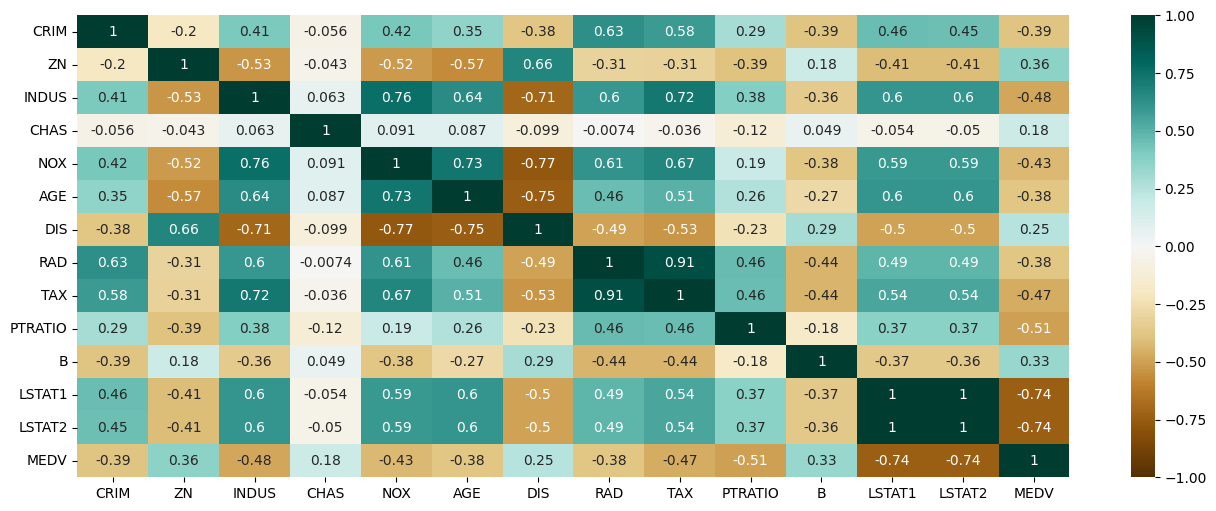

In [35]:
# 1) 상관관계 
cor_mat = df.corr()
plt.figure(figsize=(16, 6))
sns.heatmap(cor_mat, vmin = -1 , vmax = 1, cmap = 'BrBG' , annot = True)

cor_table = cor_mat.unstack().reset_index(name = 'corr')
over7 = cor_table[(cor_table['corr'] >= 0.7) & (cor_table['level_0'] != cor_table['level_1'])]
print(over7)

# 2) VIF - 독립변수만 추출해서 확
X = df.drop('MEDV', axis = 1)

vif = pd.DataFrame()
vif['col'] = X.columns 
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

In [36]:
# 해결방안 - PCA or 변수 제거 

print('''
1. 상관계수가 높은 변수 제거 
RAD, TAX : 둘 중 하나만 선택 
INDUS, NOX : 둘중 하나만 선택 
>> 모델의 해석력 증가 및 중복 정보 제거, 다중 공선성 완화 

2. 차원 축소 
여러 변수들이 강하게 상관되어있을때, 몇 개의 주성분으로 요
정보 손실 최소화, 다중공선성 완전 제거 
''')


1. 상관계수가 높은 변수 제거 
RAD, TAX : 둘 중 하나만 선택 
INDUS, NOX : 둘중 하나만 선택 
>> 모델의 해석력 증가 및 중복 정보 제거, 다중 공선성 완화 

2. 차원 축소 
여러 변수들이 강하게 상관되어있을때, 몇 개의 주성분으로 요
정보 손실 최소화, 다중공선성 완전 제거 



In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Scaling
selected_x = X[['CRIM','ZN','INDUS','CHAS','NOX','AGE','DIS' ,'TAX','PTRATIO','B','LSTAT1']]
ss = StandardScaler()
s_x = pd.DataFrame(ss.fit_transform(selected_x), columns = selected_x.columns)

# 5개의 주성분으로 PCA 수행
pca = PCA(n_components= 7)
pca_x = pd.DataFrame(pca.fit_transform(s_x) , columns = ['PC_' + str(i) for i in range(pca.n_components_)] )
pca_x.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,-1.802657,0.682938,-0.371207,-1.111284,0.129267,0.502184,-0.415990
1,-1.202733,0.450334,0.738331,-0.364257,-0.275562,0.609962,0.242310
2,-1.649884,0.371598,0.664650,-0.227853,-0.426969,0.613418,-0.511400
3,-2.341653,-0.055698,0.853334,0.201517,-0.609534,0.809609,-0.477235
4,-2.131344,-0.018475,0.888465,0.138223,-0.533677,0.811052,-0.124558


In [40]:
import statsmodels.api as sm

y = df['MEDV']
add_x = sm.add_constant(pca_x)
model = sm.OLS(y, add_x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     117.8
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          2.25e-101
Time:                        13:24:35   Log-Likelihood:                -1593.1
No. Observations:                 506   AIC:                             3202.
Df Residuals:                     498   BIC:                             3236.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5328      0.253     89.184      0.0

In [46]:
deleted_x = X[['CRIM','ZN','INDUS','CHAS','NOX','AGE','DIS' ,'TAX','PTRATIO','B','LSTAT1' ,'NOX']]
y = df['MEDV']

add_x = sm.add_constant(deleted_x)
model = sm.OLS(y, add_x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     94.14
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          1.20e-113
Time:                        13:34:05   Log-Likelihood:                -1554.3
No. Observations:                 506   AIC:                             3133.
Df Residuals:                     494   BIC:                             3183.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.0025      3.880     16.494      0.0

In [ ]:
print('''
PCA로 차원 축소시, 정보 일부가 손실됨 > 종속변수의 예측력을 극대화 하지 않음 
다중 공선성 문제는 해결되어있지만, R-squared 감소의 트레이드오프가 발생 
오히려 변수만 제거한 상태에서의 R-squared 값이 더 높다. 

이런 경우의 해결방법은 
1. 주성분 개수를 늘려 정보 손실을 줄임 
2. 다중공선성이 심한 변수만 선택적으로 제거하거나, 변수를 변환 (log 변)
''')

#### 3.3 통계 - 범주형 변수간 검정

In [47]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_s3.csv')
df.head()

,성별,급여
0,남,388.202617
1,남,320.007860
2,남,348.936899
3,남,412.044660
4,남,393.377900


In [56]:
from scipy.stats import shapiro, levene
res = []
for gender in df['성별'].unique() : 
    stat, p_val = shapiro(df[df['성별'] == gender]['급여'])
    if p_val < 0.05 : 
        decision = '귀무가설 기각 - 정규분포가 아니다'
    else : 
        decision = '귀무가설 채택 - 정규분포이다'

    res.append([gender, p_val, decision])
    
print("1.Shapiro-Wilk 정규성 검정 결과 (성별별):")
print(pd.DataFrame(res)) 


g = [group['급여'] for name, group in df.groupby('성별')]
stat, pval = levene(*g)
print("")
print("2.Levene 등분산 검정 결과")
print('''귀무가설 : 등분산이다
대립가설 : 등분산이 아니다.  '''
)
if pval < 0.05 : 
    print('귀무가설 기가 : 등분산이 아니다.')
else : 
    print('귀무가설 채택 : 등분산이다' )

1.Shapiro-Wilk 정규성 검정 결과 (성별별):
   0         1                    2
0  남  0.406490     귀무가설 채택 - 정규분포이다
1  여  0.000005  귀무가설 기각 - 정규분포가 아니다

2.Levene 등분산 검정 결과
귀무가설 : 등분산이다
대립가설 : 등분산이 아니다.  
귀무가설 채택 : 등분산이다


In [58]:
# 비모수 검정 
# - 만휘트니 (두 그룹)
# - 크루스칼 (세 그룹)
from scipy.stats import mannwhitneyu

group1 = df[df['성별']=='남']['급여']
group2 = df[df['성별']=='여']['급여']

stat, p_val = mannwhitneyu(group1,group2)

In [57]:
# 1) 정규성 & 등분산 만족 - 독립표본 T 
scipy.stats.ttest_ind(group1, group2, equal_var=True)

# 2) 정규성 & 등분산 X - Welch-T 검정
scipy.stats.ttest_ind(group1, group2, equal_var=False)

# 3) 한쪽이라도 정규성 X 
stat, p_val = mannwhitneyu(group1,group2)